In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_11123/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import time
from pyDOE import lhs
import matplotlib
# matplotlib.use('Agg')
import imageio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import shutil
import pickle
import scipy.io
import random
import math
from scipy.interpolate import griddata

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim import lr_scheduler

import warnings
warnings.filterwarnings("ignore")

In [3]:
import argparse
class Options_AC(object):
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--use_subnet', default=True, help=' use subnet or not')
        parser.add_argument('--no_cuda', action='store_true', default=False, help='disable CUDA or not')
        parser.add_argument('--dim_hidden', type=int, default=128, help='neurons in hidden layers')
        parser.add_argument('--hidden_layers', type=int, default=4, help='number of hidden layers')
        parser.add_argument('--lr', type=float, default=1e-3, help='initial learning rate')
        parser.add_argument('--epochs_Adam', type=int, default=50000, help='epochs for Adam optimizer')
        parser.add_argument('--epochs_LBFGS', type=int, default=1000, help='epochs for LBFGS optimizer')
        parser.add_argument('--newton_iter', type=int, default=100, help='newton_iter for LBFGS optimizer')
        parser.add_argument('--step_size', type=int, default=5000, help='step size in lr_scheduler for Adam optimizer')
        parser.add_argument('--gamma', type=float, default=0.9, help='gamma in lr_scheduler for Adam optimizer')
        
        self.parser = parser

    def parse(self):
        arg = self.parser.parse_args(args=[])
        # arg.cuda = False
        # arg.device = torch.device('cpu')
        arg.cuda = not arg.no_cuda and torch.cuda.is_available()
        arg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        return arg

args = Options_AC().parse()
print(args.hidden_layers)

def save_model(state, is_best=None, save_dir=None):
    last_model = os.path.join(save_dir, 'last_model.pth')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model.pth')
        shutil.copyfile(last_model, best_model)

4


In [4]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)

def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs

    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['leaky_relu', 'LeakyReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus()
    else:
        raise ValueError(f'unknown activation function: {name}')

In [5]:
seed_torch(42)

In [6]:
class Modified_MLP(nn.Module):
    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers,
                 act_name='tanh', init_name='xavier_normal'):
        super().__init__()
        self.hidden_layers = hidden_layers

        encoder_U = nn.Sequential()
        encoder_U.add_module('fc', nn.Linear(dim_in, dim_hidden, bias=True))
        encoder_U.add_module('act', activation(act_name))
        self.encoder_U = encoder_U

        encoder_V = nn.Sequential()
        encoder_V.add_module('fc', nn.Linear(dim_in, dim_hidden, bias=True))
        encoder_V.add_module('act', activation(act_name))
        self.encoder_V = encoder_V

        model = nn.Sequential()
        model.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))
        model.add_module('act0', activation(act_name))
        for i in range(1, hidden_layers):
            model.add_module(f'fc{i}', nn.Linear(dim_hidden, dim_hidden, bias=True))
            model.add_module(f'act{i}', activation(act_name))
        model.add_module(f'fc{hidden_layers}', nn.Linear(dim_hidden, dim_out, bias=True))

        self.model = model
        if init_name is not None:
            self.init_weight(init_name)

        self.size = self.model_size()

    def init_weight(self, name):
        """初始化网络参数"""

        if name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif name == 'kaiming_uniform':
            nn_init = nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {name}')

        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)
    
    def forward(self, x):
        """模型的正向传播"""
        U = self.encoder_U(x)
        V = self.encoder_V(x)
        for i in range(self.hidden_layers):
            x = self.model[2 * i](x)      # 调用线性层
            x = self.model[2 * i + 1](x)  # 调用激活层
            x = (1 - x) * U + x * V       # 特征融合
        x = self.model[-1](x)             # 调用最后一个线性层得到输出
        return x

    def model_size(self):
        """模型大小"""
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params


## 网络模型(DNN)

In [7]:
class MLP(nn.Module):
    """Deep Neural Network"""

    def __init__(self, L, M, dim_hidden, hidden_layers, dim_out,
                 act_name='tanh', init_name='xavier_normal'):
        super().__init__()
        
        dim_in = M * 2 + 2
        
        model = Modified_MLP(dim_in, dim_out, dim_hidden, hidden_layers)
        
#         model = nn.Sequential()
        
#         model.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))
#         model.add_module('act0', activation(act_name))
#         for i in range(1, hidden_layers):
#             model.add_module(f'fc{i}', nn.Linear(dim_hidden, dim_hidden, bias=True))
#             model.add_module(f'act{i}', activation(act_name))
#         model.add_module(f'fc{hidden_layers}', nn.Linear(dim_hidden, dim_out, bias=True))
            
        self.model = model
        
        self.L = L
        self.M = M
        
        if init_name is not None:
            self.init_weight(init_name)

            
        self.k = nn.Parameter(torch.arange(1, self.M+1).float(), requires_grad=False)
                    
    def init_weight(self, name):
        if name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif name == 'kaiming_uniform':
            nn_init = nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {name}')

        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)
                
    def input_encoding(self, t, x):
        w = 2.0 * math.pi / self.L
        out = torch.hstack([t, torch.ones_like(t), 
                            torch.cos(self.k * w * x), torch.sin(self.k * w * x)]) 
        
        return out    
            
    def forward(self, H):
        t = H[:, 0:1]
        x = H[:, 1:2]
        
        H = self.input_encoding(t, x)
        H = self.model(H)
        
        return H
    
    def forward_test(self, x):
        print(f"{'input':<20}{str(x.shape):<40}")
        for name, module in self.model._modules.items():
            x = module(x)
            print(f"{name:<20}{str(x.shape):<40}")
        return x

    def model_size(self):
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params

In [8]:
class DNN(nn.Module):
    """Deep Neural Network"""

    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers,
                 act_name='tanh', init_name=None):
        super().__init__()
        model = nn.Sequential()

        model.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))
        model.add_module('act0', activation(act_name))
        for i in range(1, hidden_layers):
            model.add_module(f'fc{i}', nn.Linear(dim_hidden, dim_hidden, bias=True))
            model.add_module(f'act{i}', activation(act_name))
        model.add_module(f'fc{hidden_layers}', nn.Linear(dim_hidden, dim_out, bias=True))

        self.model = model
        if init_name is not None:
            self.init_weight(init_name)

    def init_weight(self, name):
        if name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif name == 'kaiming_uniform':
            nn_init = nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {name}')

        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)

    def forward(self, x):
        return self.model(x)

    def forward_test(self, x):
        print(f"{'input':<20}{str(x.shape):<40}")
        for name, module in self.model._modules.items():
            x = module(x)
            print(f"{name:<20}{str(x.shape):<40}")
        return x

    def model_size(self):
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params

In [9]:
# model = MLP(L=2.0, M=10, dim_hidden=args.dim_hidden, hidden_layers=args.hidden_layers, dim_out=1)
model = DNN(dim_in=2, dim_out=1, dim_hidden=args.dim_hidden, hidden_layers=args.hidden_layers)
model.cuda()
args.model=model

## 数据集生成

In [10]:
class Trainset_AC():
    def __init__(self, *args):
        self.args = args
        self.shape = (self.args[1], self.args[0])
        
    def __call__(self):
        return self.data()
    
    def data(self):
        
        Nsd = self.args[0]
        n_ics = self.args[1]
        
        lb = np.array([0.0, -1.0])
        ub = np.array([1.0, 1.0])
        tx = (ub-lb)*lhs(2, Nsd)+lb
        
        lb_ics = np.array([0.0, -1.0])
        ub_ics = np.array([0.0, 1.0]) 
        tx_ics = (ub_ics-lb_ics)*lhs(2, n_ics)+lb_ics
        
        u_ics = tx_ics[:,[1]] ** 2 * np.cos(math.pi*tx_ics[:,[1]])
        
        
        tx = torch.from_numpy(tx).float().cuda()
        tx_ics = torch.from_numpy(tx_ics).float().cuda()
        u_ics = torch.from_numpy(u_ics).float().cuda()
        
        return tx, tx_ics, u_ics

In [11]:
trainset = Trainset_AC(25600, 512)
args.trainset = trainset
tx, tx_ics, u_ics = trainset()

## 训练

In [12]:
class Unet(DNN):
    """Physics Constrained Neural Networks
    """
    def __init__(self, dim_in=2, dim_out=1, dim_hidden=10, hidden_layers=5,
                 act_name='sigmoid', init_name=None):
        super().__init__(dim_in, dim_out, dim_hidden, hidden_layers,
                         act_name=act_name, init_name=init_name)
        self.model.fc5.bias.requires_grad = False
    def minmaxscaler(self, data):
        mmin = torch.min(data,dim=0)[0]
        mmax = torch.max(data,dim=0)[0]
        data = (data - mmin)/(mmax-mmin)
        output = data/torch.sum(data) * len(data)
        
        return output
    def forward(self, x):
        u = super().forward(x)
        u = self.minmaxscaler(u)
        return u

In [13]:
class Trainer_AC(object):
    def __init__(self, args):
        self.model = args.model
        self.lr = args.lr
        self.gamma = args.gamma

        self.newton_iter = args.newton_iter
        self.step_size = args.step_size
        
        self.model_name = self.model.__class__.__name__
        self.model_path = self._model_path()
        
        self.epochs_Adam = args.epochs_Adam
        self.epochs_LBFGS = args.epochs_LBFGS
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=self.lr, betas=(0.9, 0.999))
        self.optimizer_LBFGS = optim.LBFGS(self.model.parameters(),
                                            lr=0.01,
                                            max_iter=self.newton_iter,
                                            tolerance_grad=1.e-5,
                                            tolerance_change=1.e-9)
        self.scheduler = lr_scheduler.ExponentialLR(self.optimizer_Adam, gamma=self.gamma, verbose=True)
        
        # subnet(Unet)
        self.use_subnet = args.use_subnet
        self.Unet = args.Unet
        self.Unet.cuda()
        self.Unet.zero_grad()
        self.optimizer_Adam_Unet = optim.Adam(filter(lambda p: p.requires_grad==True, self.Unet.parameters()), lr=args.lr)    
        self.scheduler_Unet = lr_scheduler.ExponentialLR(self.optimizer_Adam_Unet, gamma=self.gamma, verbose=True)
        
        # data
        self.tx, self.tx_ics, self.u_ics = args.trainset()
 
        # Logger
        self.loss_log = []
        self.loss_b_log = []
        self.loss_r_log = []
        self.epoch_log = []
        
        self.loss_lbfgs_log = []
        self.loss_b_lbfgs_log = []
        self.loss_r_lbfgs_log = []
        self.epoch_lbfgs_log = []
        
        
    def _model_path(self):
        """Path to save the model"""
        if not os.path.exists('checkpoints'):
            os.mkdir('checkpoints')
        
        path = os.path.join('checkpoints', self.model_name)
        if not os.path.exists(path):
            os.mkdir(path)
        
        return path

    
    def net_r(self, tx):
        tx.requires_grad_(True)

        u = self.model(tx)

        grad_u = grad(u, tx)[0]
        u_t = grad_u[:,[0]]
        u_x = grad_u[:,[1]]
        u_xx = grad(u_x, tx)[0][:,[1]]

        residual = u_t - 0.0001*u_xx + 5*u**3 - 5*u

        return residual

    
    def net_u(self, tx):
        u = self.model(tx)
        
        return u
    
    
    def loss(self, use_ad=False):
        self.r_pred = self.net_r(self.tx)
        self.g_pred = self.net_u(self.tx_ics)

        if use_ad:

            self.r_weights = self.Unet(self.tx)
            loss_r = torch.mean((self.r_weights * self.r_pred)**2)
            loss_b = torch.mean((self.g_pred-self.u_ics)**2)
            loss = loss_r + 100*loss_b

        else:
            loss_r = torch.mean(self.r_pred**2)
            loss_b = torch.mean((self.g_pred-self.u_ics)**2)
            loss = loss_r + 100*loss_b

        return loss, loss_r, loss_b


    def train_Adam(self, mode='0'):
        """
        mode='0'：subnet参与计算，只训练主网络
        mode='1'：subnet参与计算，只训练subnet
        mode='2'：subnet参与计算，主网络和subnet对抗训练
        mode='3'：subnet不参与计算，只训练主网络
        """
        if mode == '0':
            self.optimizer_Adam.zero_grad()

            loss_value, loss_r_value, loss_b_value = self.loss(use_ad=True)
            loss_value.backward()
            self.optimizer_Adam.step()

            return loss_value.item(), loss_r_value.item(), loss_b_value.item()
        
        elif mode == '1':
            self.optimizer_Adam_Unet.zero_grad()
            loss_value, loss_r_value, loss_b_value = self.loss(use_ad=True)
            loss_value.backward()

            for name, parms in self.Unet.named_parameters():
                if parms.requires_grad==True:
                    parms.grad *= -1

            self.optimizer_Adam_Unet.step()        

            return loss_value.item(), loss_r_value.item(), loss_b_value.item()

        elif mode == '2':
            self.optimizer_Adam.zero_grad()
            self.optimizer_Adam_Unet.zero_grad()

            loss_value, loss_r_value, loss_b_value = self.loss(use_ad=True)
            loss_value.backward()
            self.optimizer_Adam.step()

            for name, parms in self.Unet.named_parameters():
                if parms.requires_grad==True:
                    parms.grad *= -1

            self.optimizer_Adam_Unet.step()

            return loss_value.item(), loss_r_value.item(), loss_b_value.item()

        else:
            self.optimizer_Adam.zero_grad()

            loss_value, loss_r_value, loss_b_value = self.loss(use_ad=False)
            loss_value.backward()
            self.optimizer_Adam.step()

            return loss_value.item(), loss_r_value.item(), loss_b_value.item()
        

    def train_LBFGS(self):
        loss_value, loss_r_value, loss_b_value = self.loss()
        
        def closure():
            loss_value, loss_r_value, loss_b_value = self.loss()

            self.optimizer_LBFGS.zero_grad()
            loss_value.backward()

            return loss_value

        self.optimizer_LBFGS.step(closure)
        loss_value = closure()
        
        return loss_value.item(), loss_r_value.item(), loss_b_value.item()
    
    
    def validate(self, epoch):
        self.model.eval()
        loss_value, loss_r_value, loss_b_value = self.loss()
        
        infos = 'Valid   ' + \
                f'Loss:{loss_value:.4e}  ' + \
                f'Loss_r:{loss_r_value:.4e} '
        print(infos)
        self.model.train()
        return loss_value.item()
    
    
    def save_both_model(self, step, epoch):
        # save backbone
        model_state = {
            'epoch': epoch,
            'state_dict': self.model.state_dict(),
        }
        backbone = os.path.join(self.model_path, 'backbone_%s_%d.pth' % (step, epoch))
        torch.save(model_state, backbone)

        # save subnet
        subnet_state = {
            'epoch': epoch,
            'state_dict': self.Unet.state_dict(),
        }    
        subnet = os.path.join(self.model_path, 'subnet_%s_%d.pth' % (step, epoch))
        torch.save(subnet_state, subnet)

    
    def train(self):
        start = time.time()
        best_loss = 1.e10
        
        # 1.只训练主网络
        for epoch in range(5000):
            loss_value, loss_r_value, loss_b_value = self.train_Adam(mode='3')    
            
            self.loss_log.append(loss_value)
            self.loss_r_log.append(loss_r_value)
            self.loss_b_log.append(loss_b_value)
            self.epoch_log.append(epoch)
            
            if (epoch+1) % 100 == 0:
                running_time = time.time() - start
                start = time.time()
                
                print(f'Epoch #  {epoch+1}/{self.epochs_Adam}' + f'    time:{running_time:.2f}' + '\n' + \
                      f'loss:{loss_value:.2e}, loss_r:{loss_r_value:.2e}, loss_b:{loss_b_value:.2e},')  
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)
                
            if (epoch+1) % 1000 == 0:
                self.save_both_model('step1', epoch+1)
                                
                # data
                self.tx, self.tx_ics, self.u_ics = args.trainset()
                
        # 2.只训练subnet      
        for epoch in range(2000):
            loss_value, loss_r_value, loss_b_value = self.train_Adam(mode='1')      
            
            self.loss_log.append(loss_value)
            self.loss_r_log.append(loss_r_value)
            self.loss_b_log.append(loss_b_value)
            self.epoch_log.append(epoch)
            
            if (epoch+1) % 100 == 0:
                running_time = time.time() - start
                start = time.time()
                
                print(f'Epoch #  {epoch+1}/{self.epochs_Adam}' + f'    time:{running_time:.2f}' + '\n' + \
                      f'loss:{loss_value:.2e}, loss_r:{loss_r_value:.2e}, loss_b:{loss_b_value:.2e},')  
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)
                
            if (epoch+1) % 1000 == 0:
                self.save_both_model('step2', epoch+1)
                                
                # data
                self.tx, self.tx_ics, self.u_ics = args.trainset()
                
                
        # 3.主网络和subnet对抗，一起训练      
        for epoch in range(self.epochs_Adam):
            loss_value, loss_r_value, loss_b_value = self.train_Adam(mode='2')
            
            self.loss_log.append(loss_value)
            self.loss_r_log.append(loss_r_value)
            self.loss_b_log.append(loss_b_value)
            self.epoch_log.append(epoch)
            
            
            if (epoch+1) % self.step_size == 0:
                self.scheduler.step()
                self.scheduler_Unet.step()
            
            if (epoch+1) % 100 == 0:
                running_time = time.time() - start
                start = time.time()
                
                print(f'Epoch #  {epoch+1}/{self.epochs_Adam}' + f'    time:{running_time:.2f}' + '\n' + \
                      f'loss:{loss_value:.2e}, loss_r:{loss_r_value:.2e}, loss_b:{loss_b_value:.2e},')  
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)  
                
            if (epoch+1) % 1000 == 0:
                self.save_both_model('step3', epoch+1)
                                
                # data
                self.tx, self.tx_ics, self.u_ics = args.trainset()
         
        
        # 使用最好的模型
        state_dict = torch.load(f'{self.model_path}/best_model.pth')
        self.model.load_state_dict(state_dict['state_dict'])
            
        # 4.只训练主网络主网络
        for epoch in range(self.epochs_Adam):
            loss_value, loss_r_value, loss_b_value = self.train_Adam(mode='3')
            
            self.loss_log.append(loss_value)
            self.loss_r_log.append(loss_r_value)
            self.loss_b_log.append(loss_b_value)
            self.epoch_log.append(epoch)
            
            
            if (epoch+1) % self.step_size == 0:
                self.scheduler.step()         
            
            if (epoch+1) % 100 == 0:
                running_time = time.time() - start
                start = time.time()
                
                print(f'Epoch #  {epoch+1}/{self.epochs_Adam}' + f'    time:{running_time:.2f}' + '\n' + \
                      f'loss:{loss_value:.2e}, loss_r:{loss_r_value:.2e}, loss_b:{loss_b_value:.2e},')  
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)  
                
            if (epoch+1) % 1000 == 0:
                self.save_both_model('step4', epoch+1) 
                
                # data
                self.tx, self.tx_ics, self.u_ics = args.trainset()

        # 5.lbfgs只训练主网络主网络    
        for epoch in range(self.epochs_LBFGS):
            loss_value, loss_r_value, loss_b_value = self.train_LBFGS()
            
            self.loss_log.append(loss_value)
            self.loss_r_log.append(loss_r_value)
            self.loss_b_log.append(loss_b_value)
            self.epoch_log.append(epoch)         
            
            if (epoch+1) % 100 == 0:
                running_time = time.time() - start
                start = time.time()
                
                print(f'Epoch #  {epoch+1}/{self.epochs_Adam + self.epochs_LBFGS}' + f'    time:{running_time:.2f}' + '\n' + \
                      f'loss:{loss_value:.2e}, loss_r:{loss_r_value:.2e}, loss_b:{loss_b_value:.2e},')  
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)
                
            if (epoch+1) % 100 == 0:
                self.save_both_model('step5', epoch+1) 
                
                # data
                self.tx, self.tx_ics, self.u_ics = args.trainset()

In [14]:
args.Unet = Unet(dim_in=2)
trainer = Trainer_AC(args)
trainer.train()

Adjusting learning rate of group 0 to 1.0000e-03.
Adjusting learning rate of group 0 to 1.0000e-03.
Epoch #  100/50000    time:2.50
loss:1.91e+00, loss_r:7.45e-01, loss_b:1.17e-02,
Valid   Loss:1.9039e+00  Loss_r:7.4081e-01 
Epoch #  200/50000    time:2.19
loss:1.63e+00, loss_r:5.79e-01, loss_b:1.05e-02,
Valid   Loss:1.6321e+00  Loss_r:5.7884e-01 
Epoch #  300/50000    time:2.19
loss:1.28e+00, loss_r:3.99e-01, loss_b:8.82e-03,
Valid   Loss:1.2619e+00  Loss_r:3.9995e-01 
Epoch #  400/50000    time:2.19
loss:7.46e-01, loss_r:2.58e-01, loss_b:4.88e-03,
Valid   Loss:7.4112e-01  Loss_r:2.5472e-01 
Epoch #  500/50000    time:2.20
loss:4.20e-01, loss_r:2.04e-01, loss_b:2.15e-03,
Valid   Loss:8.2370e-01  Loss_r:2.8370e-01 
Epoch #  600/50000    time:2.19
loss:1.61e-01, loss_r:1.41e-01, loss_b:1.99e-04,
Valid   Loss:1.6067e-01  Loss_r:1.4038e-01 
Epoch #  700/50000    time:2.19
loss:1.40e-01, loss_r:1.25e-01, loss_b:1.43e-04,
Valid   Loss:1.3933e-01  Loss_r:1.2501e-01 
Epoch #  800/50000    tim

Epoch #  1600/50000    time:2.27
loss:1.15e-01, loss_r:1.12e-01, loss_b:2.85e-05,
Valid   Loss:1.4528e-02  Loss_r:1.1678e-02 
Epoch #  1700/50000    time:2.27
loss:1.14e-01, loss_r:1.11e-01, loss_b:2.85e-05,
Valid   Loss:1.4528e-02  Loss_r:1.1678e-02 
Epoch #  1800/50000    time:2.28
loss:1.17e-01, loss_r:1.14e-01, loss_b:2.85e-05,
Valid   Loss:1.4528e-02  Loss_r:1.1678e-02 
Epoch #  1900/50000    time:2.27
loss:1.16e-01, loss_r:1.13e-01, loss_b:2.85e-05,
Valid   Loss:1.4528e-02  Loss_r:1.1678e-02 
Epoch #  2000/50000    time:2.27
loss:1.18e-01, loss_r:1.15e-01, loss_b:2.85e-05,
Valid   Loss:1.4528e-02  Loss_r:1.1678e-02 
Epoch #  100/50000    time:2.33
loss:6.95e-03, loss_r:2.99e-03, loss_b:3.96e-05,
Valid   Loss:2.2184e-02  Loss_r:1.8195e-02 
Epoch #  200/50000    time:2.28
loss:4.65e-03, loss_r:3.50e-03, loss_b:1.15e-05,
Valid   Loss:2.2267e-02  Loss_r:2.1120e-02 
Epoch #  300/50000    time:2.28
loss:6.40e-03, loss_r:5.11e-03, loss_b:1.29e-05,
Valid   Loss:2.1585e-02  Loss_r:2.0293e

Epoch #  6100/50000    time:2.29
loss:2.31e-02, loss_r:1.52e-02, loss_b:7.87e-05,
Valid   Loss:3.5614e-02  Loss_r:2.1068e-02 
Epoch #  6200/50000    time:2.28
loss:2.20e-02, loss_r:1.49e-02, loss_b:7.09e-05,
Valid   Loss:2.2782e-02  Loss_r:1.5606e-02 
Epoch #  6300/50000    time:2.29
loss:1.96e-02, loss_r:1.39e-02, loss_b:5.74e-05,
Valid   Loss:2.1353e-02  Loss_r:1.5511e-02 
Epoch #  6400/50000    time:2.29
loss:2.12e-02, loss_r:1.44e-02, loss_b:6.76e-05,
Valid   Loss:3.1217e-02  Loss_r:2.4385e-02 
Epoch #  6500/50000    time:2.29
loss:2.14e-02, loss_r:1.44e-02, loss_b:7.07e-05,
Valid   Loss:3.8867e-02  Loss_r:3.1100e-02 
Epoch #  6600/50000    time:2.29
loss:2.00e-02, loss_r:1.39e-02, loss_b:6.06e-05,
Valid   Loss:5.3391e-02  Loss_r:4.5476e-02 
Epoch #  6700/50000    time:2.30
loss:2.05e-02, loss_r:1.51e-02, loss_b:5.41e-05,
Valid   Loss:3.9123e-02  Loss_r:3.0446e-02 
Epoch #  6800/50000    time:2.29
loss:2.22e-02, loss_r:1.50e-02, loss_b:7.25e-05,
Valid   Loss:2.9109e-02  Loss_r:2.17

Epoch #  12600/50000    time:2.29
loss:2.09e-02, loss_r:1.42e-02, loss_b:6.63e-05,
Valid   Loss:2.9277e-02  Loss_r:2.2593e-02 
Epoch #  12700/50000    time:2.29
loss:2.09e-02, loss_r:1.43e-02, loss_b:6.64e-05,
Valid   Loss:2.2428e-02  Loss_r:1.5877e-02 
Epoch #  12800/50000    time:2.29
loss:2.11e-02, loss_r:1.46e-02, loss_b:6.49e-05,
Valid   Loss:2.4508e-02  Loss_r:1.7580e-02 
Epoch #  12900/50000    time:2.29
loss:2.12e-02, loss_r:1.44e-02, loss_b:6.76e-05,
Valid   Loss:2.2060e-02  Loss_r:1.5192e-02 
Epoch #  13000/50000    time:2.29
loss:2.37e-02, loss_r:1.78e-02, loss_b:5.93e-05,
Valid   Loss:2.6746e-02  Loss_r:1.3367e-02 
Epoch #  13100/50000    time:2.29
loss:2.48e-02, loss_r:1.64e-02, loss_b:8.34e-05,
Valid   Loss:2.7083e-02  Loss_r:1.2886e-02 
Epoch #  13200/50000    time:2.29
loss:2.13e-02, loss_r:1.30e-02, loss_b:8.32e-05,
Valid   Loss:2.0637e-02  Loss_r:1.5208e-02 
Epoch #  13300/50000    time:2.29
loss:2.12e-02, loss_r:1.40e-02, loss_b:7.14e-05,
Valid   Loss:2.1123e-02  Los

Epoch #  19000/50000    time:2.29
loss:2.24e-02, loss_r:1.48e-02, loss_b:7.59e-05,
Valid   Loss:2.0330e-02  Loss_r:1.2033e-02 
Epoch #  19100/50000    time:2.30
loss:2.23e-02, loss_r:1.67e-02, loss_b:5.60e-05,
Valid   Loss:3.2364e-02  Loss_r:2.3787e-02 
Epoch #  19200/50000    time:2.29
loss:2.12e-02, loss_r:1.42e-02, loss_b:6.96e-05,
Valid   Loss:3.6295e-02  Loss_r:2.9338e-02 
Epoch #  19300/50000    time:2.29
loss:2.28e-02, loss_r:1.58e-02, loss_b:7.00e-05,
Valid   Loss:3.4132e-02  Loss_r:2.7089e-02 
Epoch #  19400/50000    time:2.29
loss:2.05e-02, loss_r:1.38e-02, loss_b:6.72e-05,
Valid   Loss:1.7466e-02  Loss_r:1.0771e-02 
Epoch #  19500/50000    time:2.29
loss:2.04e-02, loss_r:1.47e-02, loss_b:5.71e-05,
Valid   Loss:1.4498e-02  Loss_r:8.8693e-03 
Epoch #  19600/50000    time:2.29
loss:2.22e-02, loss_r:1.50e-02, loss_b:7.20e-05,
Valid   Loss:1.9701e-02  Loss_r:1.2018e-02 
Epoch #  19700/50000    time:2.28
loss:2.13e-02, loss_r:1.45e-02, loss_b:6.73e-05,
Valid   Loss:2.8418e-02  Los

Epoch #  25300/50000    time:2.29
loss:4.73e-03, loss_r:3.48e-03, loss_b:1.25e-05,
Valid   Loss:4.3189e-03  Loss_r:3.0811e-03 
Epoch #  25400/50000    time:2.29
loss:4.70e-03, loss_r:3.43e-03, loss_b:1.27e-05,
Valid   Loss:4.4931e-03  Loss_r:3.0128e-03 
Epoch #  25500/50000    time:2.29
loss:4.43e-03, loss_r:3.16e-03, loss_b:1.27e-05,
Valid   Loss:4.0424e-03  Loss_r:2.6963e-03 
Epoch #  25600/50000    time:2.29
loss:5.37e-03, loss_r:3.44e-03, loss_b:1.94e-05,
Valid   Loss:6.2033e-03  Loss_r:3.3115e-03 
Epoch #  25700/50000    time:2.29
loss:4.01e-03, loss_r:2.90e-03, loss_b:1.11e-05,
Valid   Loss:3.9430e-03  Loss_r:2.8426e-03 
Epoch #  25800/50000    time:2.29
loss:3.80e-03, loss_r:2.86e-03, loss_b:9.43e-06,
Valid   Loss:3.2955e-03  Loss_r:2.3541e-03 
Epoch #  25900/50000    time:2.29
loss:3.74e-03, loss_r:2.68e-03, loss_b:1.06e-05,
Valid   Loss:3.5643e-03  Loss_r:2.5124e-03 
Epoch #  26000/50000    time:2.29
loss:3.56e-03, loss_r:2.58e-03, loss_b:9.79e-06,
Valid   Loss:3.3437e-03  Los

Epoch #  31700/50000    time:2.29
loss:1.55e-03, loss_r:1.05e-03, loss_b:4.93e-06,
Valid   Loss:1.6887e-03  Loss_r:1.1811e-03 
Epoch #  31800/50000    time:2.29
loss:1.52e-03, loss_r:1.04e-03, loss_b:4.83e-06,
Valid   Loss:1.6183e-03  Loss_r:1.1662e-03 
Epoch #  31900/50000    time:2.29
loss:1.49e-03, loss_r:1.05e-03, loss_b:4.42e-06,
Valid   Loss:1.6206e-03  Loss_r:1.1684e-03 
Epoch #  32000/50000    time:2.29
loss:1.46e-03, loss_r:1.04e-03, loss_b:4.26e-06,
Valid   Loss:1.5399e-03  Loss_r:1.1126e-03 
Epoch #  32100/50000    time:2.30
loss:2.09e-02, loss_r:4.79e-03, loss_b:1.61e-04,
Valid   Loss:1.0358e-02  Loss_r:5.3432e-03 
Epoch #  32200/50000    time:2.29
loss:9.95e-04, loss_r:8.71e-04, loss_b:1.24e-06,
Valid   Loss:1.0261e-03  Loss_r:9.0314e-04 
Epoch #  32300/50000    time:2.29
loss:9.15e-04, loss_r:8.06e-04, loss_b:1.09e-06,
Valid   Loss:9.3224e-04  Loss_r:8.2325e-04 
Epoch #  32400/50000    time:2.29
loss:8.77e-04, loss_r:7.76e-04, loss_b:1.02e-06,
Valid   Loss:8.8094e-04  Los

Epoch #  38100/50000    time:2.30
loss:6.20e-03, loss_r:4.64e-03, loss_b:1.56e-05,
Valid   Loss:8.8555e-03  Loss_r:5.2838e-03 
Epoch #  38200/50000    time:2.29
loss:5.60e-04, loss_r:4.92e-04, loss_b:6.79e-07,
Valid   Loss:5.3666e-04  Loss_r:4.6935e-04 
Epoch #  38300/50000    time:2.29
loss:5.46e-04, loss_r:4.79e-04, loss_b:6.73e-07,
Valid   Loss:5.0184e-04  Loss_r:4.3445e-04 
Epoch #  38400/50000    time:2.29
loss:5.79e-04, loss_r:4.90e-04, loss_b:8.86e-07,
Valid   Loss:5.4349e-04  Loss_r:4.1872e-04 
Epoch #  38500/50000    time:2.29
loss:5.98e-04, loss_r:4.99e-04, loss_b:9.89e-07,
Valid   Loss:5.0095e-04  Loss_r:4.0184e-04 
Epoch #  38600/50000    time:2.29
loss:7.80e-04, loss_r:5.25e-04, loss_b:2.56e-06,
Valid   Loss:5.8063e-04  Loss_r:4.3819e-04 
Epoch #  38700/50000    time:2.29
loss:6.33e-04, loss_r:4.95e-04, loss_b:1.38e-06,
Valid   Loss:6.4780e-04  Loss_r:5.0970e-04 
Epoch #  38800/50000    time:2.28
loss:2.07e-03, loss_r:1.07e-03, loss_b:1.00e-05,
Valid   Loss:2.4023e-03  Los

Epoch #  44500/50000    time:2.29
loss:6.54e-04, loss_r:4.59e-04, loss_b:1.94e-06,
Valid   Loss:1.5606e-03  Loss_r:1.3667e-03 
Epoch #  44600/50000    time:2.30
loss:5.38e-04, loss_r:3.78e-04, loss_b:1.60e-06,
Valid   Loss:1.5484e-03  Loss_r:1.3883e-03 
Epoch #  44700/50000    time:2.29
loss:5.06e-04, loss_r:3.64e-04, loss_b:1.41e-06,
Valid   Loss:9.2141e-04  Loss_r:7.8046e-04 
Epoch #  44800/50000    time:2.29
loss:4.50e-04, loss_r:3.24e-04, loss_b:1.25e-06,
Valid   Loss:5.0059e-04  Loss_r:3.7524e-04 
Epoch #  44900/50000    time:2.29
loss:2.49e-03, loss_r:6.14e-04, loss_b:1.88e-05,
Valid   Loss:1.3316e-03  Loss_r:5.3356e-04 
Adjusting learning rate of group 0 to 3.8742e-04.
Adjusting learning rate of group 0 to 3.8742e-04.
Epoch #  45000/50000    time:2.30
loss:4.38e-04, loss_r:2.96e-04, loss_b:1.42e-06,
Valid   Loss:1.6513e-03  Loss_r:1.5093e-03 
Epoch #  45100/50000    time:2.30
loss:4.59e-04, loss_r:3.38e-04, loss_b:1.21e-06,
Valid   Loss:5.7765e-04  Loss_r:4.5674e-04 
Epoch #  45

Epoch #  900/50000    time:2.19
loss:1.76e-04, loss_r:1.51e-04, loss_b:2.49e-07,
Valid   Loss:1.7586e-04  Loss_r:1.5106e-04 
Epoch #  1000/50000    time:2.19
loss:2.16e-04, loss_r:1.52e-04, loss_b:6.46e-07,
Valid   Loss:2.1382e-04  Loss_r:1.5065e-04 
Epoch #  1100/50000    time:2.19
loss:1.73e-04, loss_r:1.50e-04, loss_b:2.35e-07,
Valid   Loss:1.7306e-04  Loss_r:1.4956e-04 
Epoch #  1200/50000    time:2.19
loss:1.78e-04, loss_r:1.49e-04, loss_b:2.94e-07,
Valid   Loss:1.7949e-04  Loss_r:1.4881e-04 
Epoch #  1300/50000    time:2.19
loss:2.01e-04, loss_r:1.60e-04, loss_b:4.09e-07,
Valid   Loss:1.9622e-04  Loss_r:1.4724e-04 
Epoch #  1400/50000    time:2.19
loss:1.08e-03, loss_r:2.10e-04, loss_b:8.65e-06,
Valid   Loss:1.3242e-03  Loss_r:2.5935e-04 
Epoch #  1500/50000    time:2.19
loss:1.70e-04, loss_r:1.43e-04, loss_b:2.71e-07,
Valid   Loss:1.7239e-04  Loss_r:1.4392e-04 
Epoch #  1600/50000    time:2.19
loss:1.66e-04, loss_r:1.42e-04, loss_b:2.41e-07,
Valid   Loss:1.6587e-04  Loss_r:1.419

Epoch #  7400/50000    time:2.19
loss:1.34e-04, loss_r:1.04e-04, loss_b:2.99e-07,
Valid   Loss:1.4265e-04  Loss_r:1.0206e-04 
Epoch #  7500/50000    time:2.19
loss:1.19e-04, loss_r:1.01e-04, loss_b:1.81e-07,
Valid   Loss:1.1939e-04  Loss_r:1.0330e-04 
Epoch #  7600/50000    time:2.19
loss:1.18e-04, loss_r:1.02e-04, loss_b:1.55e-07,
Valid   Loss:1.1720e-04  Loss_r:1.0019e-04 
Epoch #  7700/50000    time:2.19
loss:1.20e-04, loss_r:1.01e-04, loss_b:1.94e-07,
Valid   Loss:1.2162e-04  Loss_r:1.0088e-04 
Epoch #  7800/50000    time:2.19
loss:1.31e-04, loss_r:1.02e-04, loss_b:2.87e-07,
Valid   Loss:1.3584e-04  Loss_r:9.9618e-05 
Epoch #  7900/50000    time:2.19
loss:1.30e-04, loss_r:1.00e-04, loss_b:3.03e-07,
Valid   Loss:1.4136e-04  Loss_r:1.0116e-04 
Epoch #  8000/50000    time:2.19
loss:2.06e-04, loss_r:1.21e-04, loss_b:8.52e-07,
Valid   Loss:2.3851e-04  Loss_r:1.3027e-04 
Epoch #  8100/50000    time:2.19
loss:9.03e-04, loss_r:1.65e-04, loss_b:7.38e-06,
Valid   Loss:1.0069e-03  Loss_r:1.51

Epoch #  13900/50000    time:2.19
loss:1.87e-04, loss_r:1.16e-04, loss_b:7.07e-07,
Valid   Loss:1.5020e-04  Loss_r:9.3923e-05 
Epoch #  14000/50000    time:2.19
loss:9.93e-05, loss_r:8.29e-05, loss_b:1.64e-07,
Valid   Loss:1.0863e-04  Loss_r:8.2799e-05 
Epoch #  14100/50000    time:2.20
loss:1.14e-04, loss_r:8.48e-05, loss_b:2.95e-07,
Valid   Loss:1.0422e-04  Loss_r:8.1577e-05 
Epoch #  14200/50000    time:2.19
loss:1.13e-04, loss_r:8.32e-05, loss_b:3.02e-07,
Valid   Loss:1.0611e-04  Loss_r:8.0390e-05 
Epoch #  14300/50000    time:2.19
loss:9.96e-05, loss_r:8.34e-05, loss_b:1.62e-07,
Valid   Loss:9.6586e-05  Loss_r:8.1950e-05 
Epoch #  14400/50000    time:2.19
loss:2.04e-04, loss_r:8.68e-05, loss_b:1.17e-06,
Valid   Loss:2.2501e-04  Loss_r:9.0464e-05 
Epoch #  14500/50000    time:2.19
loss:1.12e-04, loss_r:8.50e-05, loss_b:2.71e-07,
Valid   Loss:1.1485e-04  Loss_r:9.0499e-05 
Epoch #  14600/50000    time:2.19
loss:1.07e-04, loss_r:8.09e-05, loss_b:2.61e-07,
Valid   Loss:1.1147e-04  Los

Epoch #  20300/50000    time:2.20
loss:8.72e-05, loss_r:6.64e-05, loss_b:2.08e-07,
Valid   Loss:9.3666e-05  Loss_r:6.7257e-05 
Epoch #  20400/50000    time:2.20
loss:7.38e-05, loss_r:6.42e-05, loss_b:9.58e-08,
Valid   Loss:7.2738e-05  Loss_r:6.4378e-05 
Epoch #  20500/50000    time:2.19
loss:7.72e-05, loss_r:6.52e-05, loss_b:1.20e-07,
Valid   Loss:7.7725e-05  Loss_r:6.7253e-05 
Epoch #  20600/50000    time:2.18
loss:1.04e-04, loss_r:6.73e-05, loss_b:3.66e-07,
Valid   Loss:1.0909e-04  Loss_r:6.7901e-05 
Epoch #  20700/50000    time:2.19
loss:8.18e-05, loss_r:6.95e-05, loss_b:1.23e-07,
Valid   Loss:9.0513e-05  Loss_r:6.9747e-05 
Epoch #  20800/50000    time:2.19
loss:7.15e-05, loss_r:6.37e-05, loss_b:7.83e-08,
Valid   Loss:7.1269e-05  Loss_r:6.3358e-05 
Epoch #  20900/50000    time:2.19
loss:7.89e-05, loss_r:6.30e-05, loss_b:1.59e-07,
Valid   Loss:8.1415e-05  Loss_r:6.3345e-05 
Epoch #  21000/50000    time:2.19
loss:3.50e-04, loss_r:9.30e-05, loss_b:2.57e-06,
Valid   Loss:3.8858e-04  Los

Epoch #  26800/50000    time:2.19
loss:6.66e-05, loss_r:5.51e-05, loss_b:1.15e-07,
Valid   Loss:6.9306e-05  Loss_r:5.5174e-05 
Epoch #  26900/50000    time:2.19
loss:1.07e-04, loss_r:5.78e-05, loss_b:4.89e-07,
Valid   Loss:8.3882e-05  Loss_r:5.8954e-05 
Epoch #  27000/50000    time:2.19
loss:6.47e-05, loss_r:5.37e-05, loss_b:1.10e-07,
Valid   Loss:6.4682e-05  Loss_r:5.3822e-05 
Epoch #  27100/50000    time:2.20
loss:1.49e-04, loss_r:8.03e-05, loss_b:6.84e-07,
Valid   Loss:1.4315e-04  Loss_r:7.6845e-05 
Epoch #  27200/50000    time:2.19
loss:2.90e-04, loss_r:7.74e-05, loss_b:2.13e-06,
Valid   Loss:2.2365e-04  Loss_r:6.1547e-05 
Epoch #  27300/50000    time:2.19
loss:5.72e-05, loss_r:5.12e-05, loss_b:5.98e-08,
Valid   Loss:5.7006e-05  Loss_r:5.0942e-05 
Epoch #  27400/50000    time:2.19
loss:5.65e-05, loss_r:5.06e-05, loss_b:5.99e-08,
Valid   Loss:5.6543e-05  Loss_r:5.0554e-05 
Epoch #  27500/50000    time:2.19
loss:5.74e-05, loss_r:5.06e-05, loss_b:6.80e-08,
Valid   Loss:5.9654e-05  Los

Epoch #  33300/50000    time:2.19
loss:5.61e-05, loss_r:4.73e-05, loss_b:8.86e-08,
Valid   Loss:5.6065e-05  Loss_r:4.8312e-05 
Epoch #  33400/50000    time:2.19
loss:1.68e-04, loss_r:5.04e-05, loss_b:1.17e-06,
Valid   Loss:1.9365e-04  Loss_r:5.5628e-05 
Epoch #  33500/50000    time:2.19
loss:5.42e-05, loss_r:4.69e-05, loss_b:7.24e-08,
Valid   Loss:5.4660e-05  Loss_r:4.7481e-05 
Epoch #  33600/50000    time:2.18
loss:1.42e-04, loss_r:5.34e-05, loss_b:8.86e-07,
Valid   Loss:1.3202e-04  Loss_r:5.3016e-05 
Epoch #  33700/50000    time:2.19
loss:7.75e-05, loss_r:5.33e-05, loss_b:2.42e-07,
Valid   Loss:7.7575e-05  Loss_r:5.1630e-05 
Epoch #  33800/50000    time:2.19
loss:6.19e-05, loss_r:4.63e-05, loss_b:1.56e-07,
Valid   Loss:6.4783e-05  Loss_r:4.6056e-05 
Epoch #  33900/50000    time:2.19
loss:1.15e-04, loss_r:7.40e-05, loss_b:4.08e-07,
Valid   Loss:8.2736e-05  Loss_r:5.8005e-05 
Epoch #  34000/50000    time:2.19
loss:5.05e-05, loss_r:4.52e-05, loss_b:5.23e-08,
Valid   Loss:5.0462e-05  Los

Epoch #  39800/50000    time:2.19
loss:1.85e-04, loss_r:5.22e-05, loss_b:1.33e-06,
Valid   Loss:2.5881e-04  Loss_r:5.4296e-05 
Epoch #  39900/50000    time:2.19
loss:4.40e-05, loss_r:3.95e-05, loss_b:4.50e-08,
Valid   Loss:4.4008e-05  Loss_r:3.9470e-05 
Adjusting learning rate of group 0 to 1.5009e-04.
Epoch #  40000/50000    time:2.19
loss:4.40e-05, loss_r:3.95e-05, loss_b:4.43e-08,
Valid   Loss:4.3917e-05  Loss_r:3.9373e-05 
Epoch #  40100/50000    time:2.20
loss:4.56e-05, loss_r:4.11e-05, loss_b:4.51e-08,
Valid   Loss:4.5581e-05  Loss_r:4.1073e-05 
Epoch #  40200/50000    time:2.19
loss:4.55e-05, loss_r:4.08e-05, loss_b:4.72e-08,
Valid   Loss:4.5497e-05  Loss_r:4.0929e-05 
Epoch #  40300/50000    time:2.19
loss:4.64e-05, loss_r:4.08e-05, loss_b:5.57e-08,
Valid   Loss:4.6204e-05  Loss_r:4.0680e-05 
Epoch #  40400/50000    time:2.19
loss:4.52e-05, loss_r:4.05e-05, loss_b:4.71e-08,
Valid   Loss:4.5266e-05  Loss_r:4.0622e-05 
Epoch #  40500/50000    time:2.19
loss:2.01e-04, loss_r:5.23e

Epoch #  46200/50000    time:2.19
loss:6.82e-05, loss_r:4.92e-05, loss_b:1.90e-07,
Valid   Loss:7.1244e-05  Loss_r:4.7590e-05 
Epoch #  46300/50000    time:2.19
loss:4.51e-05, loss_r:3.78e-05, loss_b:7.30e-08,
Valid   Loss:4.4759e-05  Loss_r:3.8102e-05 
Epoch #  46400/50000    time:2.19
loss:5.12e-05, loss_r:3.79e-05, loss_b:1.33e-07,
Valid   Loss:5.2063e-05  Loss_r:3.7629e-05 
Epoch #  46500/50000    time:2.18
loss:4.20e-05, loss_r:3.75e-05, loss_b:4.51e-08,
Valid   Loss:4.2002e-05  Loss_r:3.7557e-05 
Epoch #  46600/50000    time:2.19
loss:5.92e-05, loss_r:3.94e-05, loss_b:1.98e-07,
Valid   Loss:5.2439e-05  Loss_r:3.8658e-05 
Epoch #  46700/50000    time:2.19
loss:4.33e-05, loss_r:3.77e-05, loss_b:5.68e-08,
Valid   Loss:4.3196e-05  Loss_r:3.7393e-05 
Epoch #  46800/50000    time:2.19
loss:4.28e-05, loss_r:3.75e-05, loss_b:5.26e-08,
Valid   Loss:4.2510e-05  Loss_r:3.7725e-05 
Epoch #  46900/50000    time:2.19
loss:4.18e-05, loss_r:3.73e-05, loss_b:4.49e-08,
Valid   Loss:4.1937e-05  Los

In [15]:
# 使用最好的模型
state_dict = torch.load(f'{trainer.model_path}/best_model.pth')
model.load_state_dict(state_dict['state_dict'])

<All keys matched successfully>

In [16]:
file = f'checkpoints/subnet,{args.epochs_Adam}Adam,{args.epochs_LBFGS}LBFGS'
if os.path.exists(file)==False:
    os.mkdir(file)

In [17]:
np.save(f'{file}/loss_r_log.npy',np.array(trainer.loss_r_log))
np.save(f'{file}/loss_b_log.npy',np.array(trainer.loss_b_log))

In [18]:
trainer.loss_r_log = np.load(f'{file}/loss_r_log.npy')
trainer.loss_b_log = np.load(f'{file}/loss_b_log.npy')

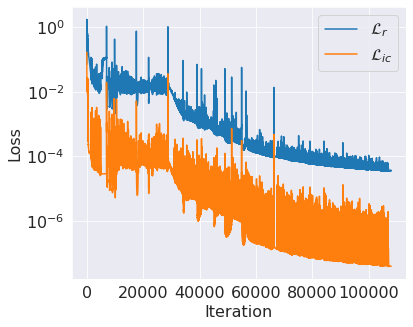

In [19]:
import seaborn as sns
with sns.axes_style("darkgrid"):
    fig = plt.figure(figsize=(6, 5))
    plt.rcParams.update({'font.size':16})
    plt.plot(np.arange(len(trainer.loss_r_log)), trainer.loss_r_log, label='$ \mathcal{L}_r$')
    plt.plot(np.arange(len(trainer.loss_b_log)), trainer.loss_b_log, label='$ \mathcal{L}_{ic}$')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.legend()
    plt.savefig(f'{file}/loss.jpg', dpi=750, bbox_inches = 'tight')

## 预测

In [20]:
model.cpu();
trainer.Unet.cpu();

Text(0, 0.5, '$x$')

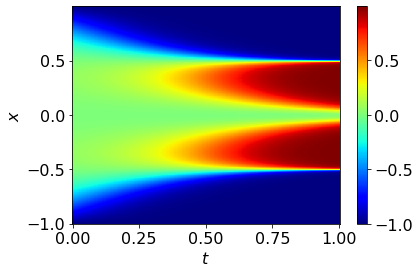

In [21]:
# load the data
data = scipy.io.loadmat('AC.mat')
usol = data['uu']

# Grid
t_star = data['tt'][0]
x_star = data['x'][0]
TT, XX = np.meshgrid(t_star, x_star)

# Reference solution
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')

In [22]:
# Get trained network parameters
TX = np.hstack((TT.reshape(-1,1), XX.reshape(-1,1)))
TX = torch.from_numpy(TX).double()

model = trainer.model.cpu().double()
u_pred = model(TX).detach().numpy()
u_pred = u_pred.reshape(TT.shape)

error = np.linalg.norm(u_pred - usol) / np.linalg.norm(usol) 
print('Relative l2 error: {:.3e}'.format(error))

Relative l2 error: 6.187e-02


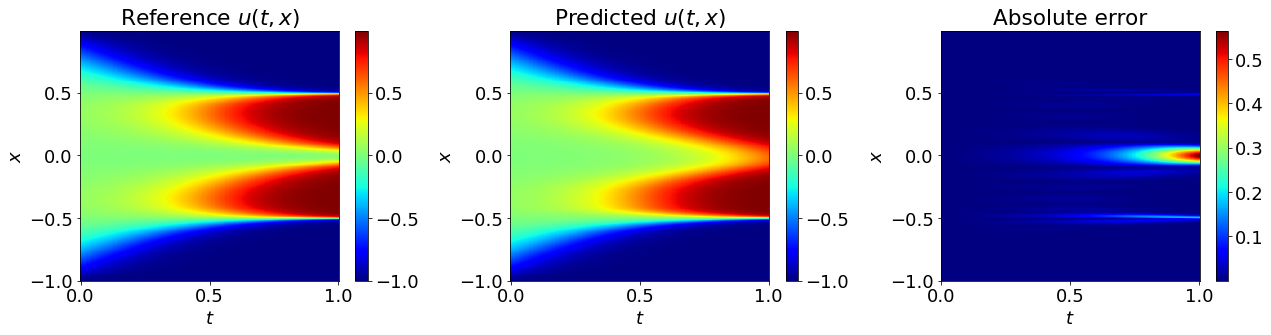

In [23]:
plt.rcParams.update({'font.size':18})

fig = plt.figure(3, figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.pcolor(TT, XX, usol, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Reference $u(t,x)$')
plt.tight_layout()

plt.subplot(1, 3, 2)
plt.pcolor(TT, XX, u_pred, cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Predicted $u(t,x)$')
plt.tight_layout()

plt.subplot(1, 3, 3)
plt.pcolor(TT, XX, np.abs(usol - u_pred), cmap='jet')
plt.colorbar()
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title(r'Absolute error')
plt.tight_layout()

plt.savefig(f'{file}/results_ac.jpg', dpi=750, bbox_inches = 'tight')
plt.show()